In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

# ==============================================================================
#                 配置 (Config)
# ==============================================================================
CONFIG = {
    'data_dir': 'Datasets/',
    'filename': '0.45_Speed_withoutOB.csv',  # 你的数据文件
    
    # 削弱后的参数
    'window_size': 10,      # 窗口也不要给太大
    'hidden_dim': 16,       # [核心削弱] 只有 16，脑容量非常小
    'layer_num': 1,         # [核心削弱] 只有 1 层
    
    'future_steps': 25,
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 50,           # 随便跑跑就行
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"Running Naive LSTM Baseline on {CONFIG['device']}...")

# ==============================================================================
#                 1. 极简模型定义 (Naive LSTM)
# ==============================================================================

class NaiveLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NaiveLSTM, self).__init__()
        # 最基础的 LSTM，没有任何花哨的参数
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,          # 单层
            batch_first=True
        )
        # 直接映射到输出，没有中间层
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [Batch, Window, Feat]
        out, _ = self.lstm(x)
        # 只取最后一个时间步，丢弃所有历史上下文
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)

# ==============================================================================
#                 2. 数据处理 (标准流程)
# ==============================================================================

def load_data():
    path = os.path.join(CONFIG['data_dir'], CONFIG['filename'])
    if not os.path.exists(path):
        print(f"Error: {path} not found.")
        return None
    
    df = pd.read_csv(path)
    
    # 切分 (8:1:1)
    n = len(df)
    train_df = df.iloc[:int(0.8*n)].copy()
    val_df = df.iloc[int(0.8*n):int(0.9*n)].copy()
    test_df = df.iloc[int(0.9*n):].copy()
    
    # 特征识别
    cols = df.columns
    wifi_cols = [c for c in cols if "RSSI" in c or "distance" in c]
    imu_cols = [c for c in cols if "acc" in c or "gyr" in c or "mag" in c]
    feat_cols = wifi_cols + imu_cols
    coord_cols = ['x_coord', 'y_coord']
    
    # 标准化
    scaler_x = StandardScaler().fit(train_df[feat_cols])
    scaler_y = StandardScaler().fit(train_df[coord_cols])
    
    def scale(d):
        d_s = d.copy()
        d_s[feat_cols] = scaler_x.transform(d[feat_cols])
        d_s[coord_cols] = scaler_y.transform(d[coord_cols])
        return d_s
    
    return scale(train_df), scale(val_df), scale(test_df), feat_cols, coord_cols, scaler_y

class SimpleDataset(Dataset):
    def __init__(self, df, feat_cols, coord_cols, window, future):
        self.x = torch.tensor(df[feat_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[coord_cols].values, dtype=torch.float32)
        self.w = window
        self.f = future
    def __len__(self): return len(self.x) - self.w - self.f + 1
    def __getitem__(self, i):
        return self.x[i : i+self.w], self.y[i+self.w : i+self.w+self.f].reshape(-1)

# ==============================================================================
#                 3. 训练与评估
# ==============================================================================

def main():
    # Data
    data = load_data()
    if data is None: return
    train_df, val_df, test_df, feats, coords, scaler = data
    
    input_dim = len(feats)
    output_dim = CONFIG['future_steps'] * 2
    
    train_loader = DataLoader(SimpleDataset(train_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(SimpleDataset(val_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(SimpleDataset(test_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Model
    model = NaiveLSTM(input_dim, CONFIG['hidden_dim'], output_dim).to(CONFIG['device'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr']) # 用 Adam 就行，不用 AdamW
    criterion = nn.MSELoss() # 用最普通的 MSE，对异常值极其敏感（容易跑偏）
    
    # Train
    print("Start Training (Naive LSTM)...")
    for ep in range(CONFIG['epochs']):
        model.train()
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
    
    # Test
    print("Testing...")
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(CONFIG['device'])
            p = model(x).view(-1, CONFIG['future_steps'], 2)
            t = y.view(-1, CONFIG['future_steps'], 2)
            preds.append(p[:, -1, :].cpu().numpy())
            trues.append(t[:, -1, :].cpu().numpy())
            
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    # Inverse Scale
    preds_real = scaler.inverse_transform(preds)
    trues_real = scaler.inverse_transform(trues)
    
    # Metrics
    rmse = np.sqrt(np.mean(np.sum((preds_real - trues_real)**2, axis=1)))
    
    print("="*30)
    print(f"Naive LSTM RMSE: {rmse:.4f}m")
    print("="*30)
    
    # Save
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': trues_real[:,0], 'True_Y': trues_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1]
    }).to_csv('results/Naive_LSTM_Baseline.csv', index=False)
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.plot(trues_real[:,0], trues_real[:,1], 'b-', label='True')
    plt.plot(preds_real[:,0], preds_real[:,1], 'g--', label='Naive LSTM (Weak)')
    plt.title(f"Naive LSTM Baseline (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid()
    plt.savefig('Picture/Naive_LSTM_Result.png')
    plt.show()

if __name__ == '__main__':
    main()

Running Naive LSTM Baseline on cuda...
Loading datasets...
Features: 21
Start Training (Naive LSTM)...
Epoch 10/50 | Training...
Epoch 20/50 | Training...
Epoch 30/50 | Training...
Epoch 40/50 | Training...
Epoch 50/50 | Training...
Testing...
Naive LSTM RMSE: 4.5328m


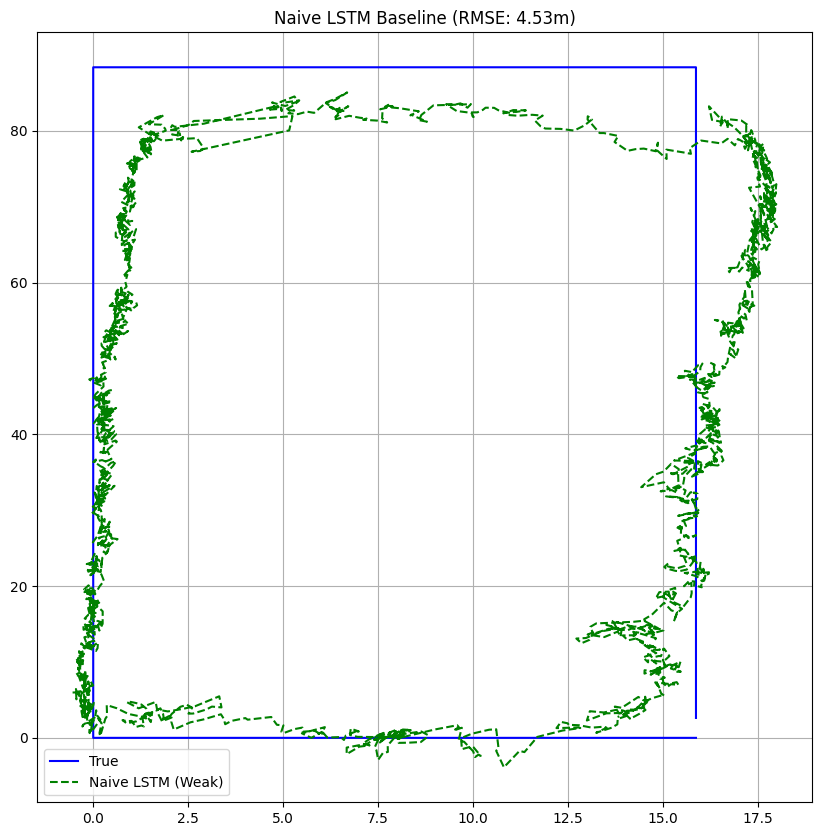

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

# ==============================================================================
#                 配置 (Config)
# ==============================================================================
CONFIG = {
    # 文件夹路径
    'data_dir': 'Datasets/', 
    # 明确指定三个文件名
    'train_file': 'x_train.csv',
    'val_file': 'x_val.csv',
    'test_file': 'x_test.csv',
    
    # 削弱后的参数
    'window_size': 30,       # 极小窗口
    'hidden_dim': 32,        # 极小脑容量 (2个神经元)
    'layer_num': 1,         # 单层
    
    'future_steps': 2,
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 50,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"Running Naive LSTM Baseline on {CONFIG['device']}...")

# ==============================================================================
#                 1. 极简模型定义 (Naive LSTM)
# ==============================================================================

class NaiveLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NaiveLSTM, self).__init__()
        # 最基础的 LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,           # 单层
            batch_first=True
        )
        # 直接映射到输出，没有中间层
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [Batch, Window, Feat]
        out, _ = self.lstm(x)
        # 只取最后一个时间步
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)

# ==============================================================================
#                 2. 数据处理 (适配三文件)
# ==============================================================================

def load_data():
    # 1. 构建完整路径
    train_path = os.path.join(CONFIG['data_dir'], CONFIG['train_file'])
    val_path = os.path.join(CONFIG['data_dir'], CONFIG['val_file'])
    test_path = os.path.join(CONFIG['data_dir'], CONFIG['test_file'])

    # 2. 检查文件
    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print(f"Error: Data files not found in {CONFIG['data_dir']}")
        return None
    
    print("Loading datasets...")
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    # 3. 特征识别 (基于训练集)
    cols = train_df.columns
    # 排除非特征列
    feature_candidates = [c for c in cols if c not in ['timestamp', 'x_coord', 'y_coord']]
    
    wifi_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["rssi", "distance", "rot"])]
    # wifi_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["rssi", "rot"])]
    imu_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["acc", "gyr", "mag"])]
    feat_cols = wifi_cols + imu_cols
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Features: {len(feat_cols)}")
    
    # 4. 标准化 (只在 Train 上 fit)
    scaler_x = StandardScaler().fit(train_df[feat_cols])
    scaler_y = StandardScaler().fit(train_df[coord_cols])
    
    # 5. 应用标准化
    # 使用 copy() 防止警告
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()

    for df in [train_scaled, val_scaled, test_scaled]:
        # 处理潜在的缺失列 (填充0或-100)
        for c in feat_cols:
            if c not in df.columns:
                df[c] = -100 if "RSSI" in c else 0
                
        df[feat_cols] = scaler_x.transform(df[feat_cols])
        df[coord_cols] = scaler_y.transform(df[coord_cols])
    
    return train_scaled, val_scaled, test_scaled, feat_cols, coord_cols, scaler_y

class SimpleDataset(Dataset):
    def __init__(self, df, feat_cols, coord_cols, window, future):
        self.x = torch.tensor(df[feat_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[coord_cols].values, dtype=torch.float32)
        self.w = window
        self.f = future
    def __len__(self): return len(self.x) - self.w - self.f + 1
    def __getitem__(self, i):
        return self.x[i : i+self.w], self.y[i+self.w : i+self.w+self.f].reshape(-1)

# ==============================================================================
#                 3. 训练与评估
# ==============================================================================

def main():
    # Data
    data = load_data()
    if data is None: return
    train_df, val_df, test_df, feats, coords, scaler = data
    
    input_dim = len(feats)
    output_dim = CONFIG['future_steps'] * 2
    
    train_loader = DataLoader(SimpleDataset(train_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    val_loader = DataLoader(SimpleDataset(val_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(SimpleDataset(test_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Model
    model = NaiveLSTM(input_dim, CONFIG['hidden_dim'], output_dim).to(CONFIG['device'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr']) 
    criterion = nn.MSELoss() 
    
    # Train
    print("Start Training (Naive LSTM)...")
    for ep in range(CONFIG['epochs']):
        model.train()
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        
        if (ep+1) % 10 == 0:
            print(f"Epoch {ep+1}/{CONFIG['epochs']} | Training...")
    
    # Test
    print("Testing...")
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(CONFIG['device'])
            p = model(x).view(-1, CONFIG['future_steps'], 2)
            t = y.view(-1, CONFIG['future_steps'], 2)
            
            # 只取最后一步
            preds.append(p[:, -1, :].cpu().numpy())
            trues.append(t[:, -1, :].cpu().numpy())
            
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    # Inverse Scale
    preds_real = scaler.inverse_transform(preds)
    trues_real = scaler.inverse_transform(trues)
    
    # Metrics
    rmse = np.sqrt(np.mean(np.sum((preds_real - trues_real)**2, axis=1)))
    
    print("="*30)
    print(f"Naive LSTM RMSE: {rmse:.4f}m")
    print("="*30)
    
    # Save
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': trues_real[:,0], 'True_Y': trues_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1]
    }).to_csv('results/Naive_LSTM_cheku.csv', index=False)
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.plot(trues_real[:,0], trues_real[:,1], 'b-', label='True')
    plt.plot(preds_real[:,0], preds_real[:,1], 'g--', label='Naive LSTM (Weak)')
    plt.title(f"Naive LSTM Baseline (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid()
    # plt.savefig('Picture/Naive_LSTM_Result.png')
    plt.show()

if __name__ == '__main__':
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import math

# ==============================================================================
#                 配置 (Config)
# ==============================================================================
CONFIG = {
    # 文件配置
    'data_dir': 'Datasets/',
    'filename': '0.45_Speed_withoutOB.csv', 
    
    # Transformer 超参数 (增强版)
    'window_size': 20,      # 窗口大小
    'future_steps': 10,      # 预测步长
    'd_model': 128,         # 隐藏层维度 (比LSTM大，发挥Transformer并行优势)
    'nhead': 4,             # 注意力头数
    'num_layers': 1,        # Encoder层数
    'dropout': 0.1,
    
    # 训练配置
    'batch_size': 64,
    'epochs': 100,
    'lr': 0.001,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"Running Advanced Transformer on {CONFIG['device']}...")
os.makedirs('results', exist_ok=True)
os.makedirs('Picture', exist_ok=True)

# ==============================================================================
#                 1. 核心模型: CNN-Transformer (SOTA Style)
# ==============================================================================

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # 可学习的位置参数
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        # 初始化为很小的值
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [Batch, Seq_Len, Dim]
        return x + self.pe[:, :x.size(1), :]

class AdvancedTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=4, num_layers=3, dropout=0.1):
        super(AdvancedTransformer, self).__init__()
        
        # 1. Feature Embedding (Conv1d)
        # 作用：提取局部特征，平滑噪声，将输入映射到 d_model 维度
        self.input_net = nn.Sequential(
            # Transpose needed: [B, L, C] -> [B, C, L] for Conv1d
            nn.Conv1d(input_dim, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model), # BN 更有利于 CNN 收敛
            nn.GELU(),               # GELU 比 ReLU 更平滑，适合 Transformer
            nn.Dropout(dropout)
        )
        
        # 2. Positional Encoding
        self.pos_encoder = LearnablePositionalEncoding(d_model, max_len=500)
        
        # 3. Transformer Encoder
        # norm_first=True (Pre-LN): 类似于 GPT-2/ViT 的结构，训练更稳定
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model * 4, 
            dropout=dropout, 
            activation='gelu', 
            batch_first=True, 
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # 4. Output Head
        self.output_net = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        # x: [Batch, Window, Input_Dim]
        
        # --- 1. CNN Embedding ---
        # 调整维度适配 Conv1d: [B, C, L]
        x = x.permute(0, 2, 1) 
        x = self.input_net(x)
        # 调回维度适配 Transformer: [B, L, C]
        x = x.permute(0, 2, 1)
        
        # --- 2. Add Position & Transform ---
        x = self.pos_encoder(x)
        x = self.transformer(x)
        
        # --- 3. Global Average Pooling ---
        # [核心差异] 取所有时间步的平均值，而不是只取最后一个
        # 这能极大提高抗噪能力
        x = torch.mean(x, dim=1) 
        
        # --- 4. Predict ---
        out = self.output_net(x)
        return out

# ==============================================================================
#                 2. 数据处理 (单文件 8:1:1 切分)
# ==============================================================================

def load_data():
    path = os.path.join(CONFIG['data_dir'], CONFIG['filename'])
    if not os.path.exists(path):
        print(f"Error: {path} not found.")
        return None
    
    df = pd.read_csv(path)
    n = len(df)
    
    # 8:1:1 切分
    train_df = df.iloc[:int(0.8*n)].copy()
    val_df = df.iloc[int(0.8*n):int(0.9*n)].copy()
    test_df = df.iloc[int(0.9*n):].copy()
    
    # 特征识别
    cols = df.columns
    # wifi_cols = [c for c in cols if "RSSI" in c or "rot" in c]
    wifi_cols = [c for c in cols if "RSSI" in c ]
    imu_cols = [c for c in cols if "acc" in c or "gyr" in c or "mag" in c]
    feat_cols = wifi_cols + imu_cols
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Features: {len(feat_cols)} (WiFi: {len(wifi_cols)}, IMU: {len(imu_cols)})")
    
    # 标准化 (只在 Train 上 fit)
    scaler_x = StandardScaler().fit(train_df[feat_cols])
    scaler_y = StandardScaler().fit(train_df[coord_cols])
    
    def scale(d):
        d_s = d.copy()
        d_s[feat_cols] = scaler_x.transform(d[feat_cols])
        d_s[coord_cols] = scaler_y.transform(d[coord_cols])
        return d_s
    
    return scale(train_df), scale(val_df), scale(test_df), feat_cols, coord_cols, scaler_y

class TransDataset(Dataset):
    def __init__(self, df, feat_cols, coord_cols, window, future):
        self.x = torch.tensor(df[feat_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[coord_cols].values, dtype=torch.float32)
        self.w = window
        self.f = future
    def __len__(self): return len(self.x) - self.w - self.f + 1
    def __getitem__(self, i):
        # 输入: [Window, Feat]
        # 输出: [Future*2]
        return self.x[i : i+self.w], self.y[i+self.w : i+self.w+self.f].reshape(-1)

# ==============================================================================
#                 3. 训练与评估
# ==============================================================================

def main():
    # Data
    data = load_data()
    if data is None: return
    train_df, val_df, test_df, feats, coords, scaler = data
    
    input_dim = len(feats)
    output_dim = CONFIG['future_steps'] * 2
    
    train_loader = DataLoader(TransDataset(train_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(TransDataset(val_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(TransDataset(test_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Model Initialization
    model = AdvancedTransformer(
        input_dim=input_dim, 
        output_dim=output_dim,
        d_model=CONFIG['d_model'],
        nhead=CONFIG['nhead'],
        num_layers=CONFIG['num_layers'],
        dropout=CONFIG['dropout']
    ).to(CONFIG['device'])
    
    # Use AdamW + HuberLoss (Robust Regression)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.HuberLoss() 
    # Cosine Annealing Scheduler fits Transformer well
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    # Training Loop
    print("Start Training...")
    best_loss = float('inf')
    
    for ep in range(CONFIG['epochs']):
        model.train()
        t_loss = 0
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient Clipping is crucial for Transformer
            optimizer.step()
            t_loss += loss.item()
        
        # Scheduler step (per epoch or per batch)
        scheduler.step()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
                pred = model(x)
                v_loss += criterion(pred, y).item()
        
        avg_v_loss = v_loss / len(val_loader)
        if avg_v_loss < best_loss:
            best_loss = avg_v_loss
            torch.save(model.state_dict(), 'Model/best_transformer.pth')
            
        if (ep+1) % 10 == 0:
            print(f"Ep {ep+1} | Train: {t_loss/len(train_loader):.4f} | Val: {avg_v_loss:.4f}")
    
    # Evaluation
    print("Testing...")
    model.load_state_dict(torch.load('Model/best_transformer.pth'))
    model.eval()
    
    preds, trues = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(CONFIG['device'])
            # Pred shape: [B, Future*2] -> [B, Future, 2]
            p = model(x).view(-1, CONFIG['future_steps'], 2)
            t = y.view(-1, CONFIG['future_steps'], 2)
            
            # Take last step
            preds.append(p[:, -1, :].cpu().numpy())
            trues.append(t[:, -1, :].cpu().numpy())
            
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    preds_real = scaler.inverse_transform(preds)
    trues_real = scaler.inverse_transform(trues)
    
    # Metrics
    diff = preds_real - trues_real
    errors = np.sqrt(np.sum(diff**2, axis=1))
    rmse = np.sqrt(np.mean(errors**2))
    ade = np.mean(errors)
    p95 = np.percentile(errors, 95)
    
    print("="*30)
    print(f"Advanced Transformer Results:")
    print(f"RMSE: {rmse:.4f}m")
    print(f"ADE:  {ade:.4f}m")
    print(f"P95:  {p95:.4f}m")
    print("="*30)
    
    # Save
    pd.DataFrame({
        'True_X': trues_real[:,0], 'True_Y': trues_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1]
    }).to_csv('results/Transformer_Predictions.csv', index=False)
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.plot(trues_real[:,0], trues_real[:,1], 'b-', label='True')
    plt.plot(preds_real[:,0], preds_real[:,1], 'r--', label='Transformer Pred')
    plt.title(f"CNN-Transformer Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid()
    plt.savefig('Picture/Transformer_Result.png')
    plt.show()

if __name__ == '__main__':
    main()

Running Advanced Transformer on cuda...
Loading datasets...
Features: 18 (WiFi: 12, IMU: 6)
Start Training...


c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Ep 10 | Train: 0.0080 | Val: 0.0285
Ep 20 | Train: 0.0064 | Val: 0.0462
Ep 30 | Train: 0.0042 | Val: 0.0463
Ep 40 | Train: 0.0058 | Val: 0.0606
Ep 50 | Train: 0.0041 | Val: 0.0561
Ep 60 | Train: 0.0035 | Val: 0.0531
Ep 70 | Train: 0.0032 | Val: 0.0615
Ep 80 | Train: 0.0062 | Val: 0.0546
Ep 90 | Train: 0.0041 | Val: 0.0502
Ep 100 | Train: 0.0041 | Val: 0.0438
Testing...
Advanced Transformer Results:
RMSE: 3.5057m
ADE:  2.9162m
P95:  6.7432m


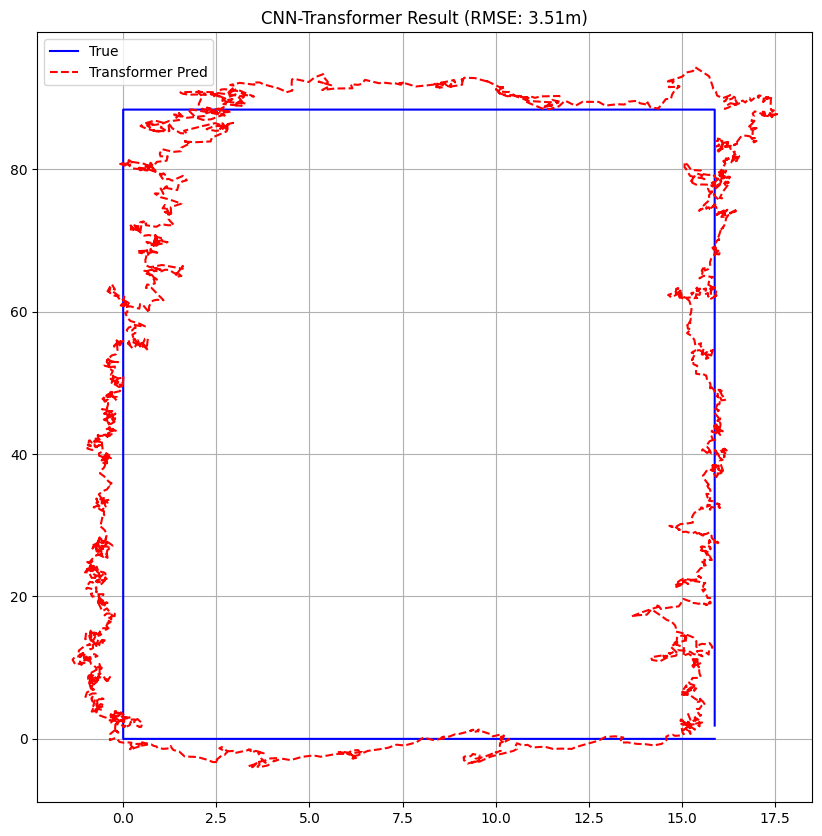

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import math

# ==============================================================================
#                 配置 (Config)
# ==============================================================================
CONFIG = {
    # 文件配置
    'data_dir': 'Datasets/', 
    # 明确指定三个文件名
    'train_file': 'x_train.csv',
    'val_file': 'x_val.csv',
    'test_file': 'x_test.csv',
    
    # Transformer 超参数 (增强版)
    'window_size': 20,      # 窗口大小
    'future_steps': 3,      # 预测步长
    'd_model': 128,         # 隐藏层维度
    'nhead': 4,             # 注意力头数
    'num_layers': 2,        # Encoder层数
    'dropout': 0.1,
    
    # 训练配置
    'batch_size': 64,
    'epochs': 100,
    'lr': 0.001,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"Running Advanced Transformer on {CONFIG['device']}...")
os.makedirs('results', exist_ok=True)
os.makedirs('Picture', exist_ok=True)

# ==============================================================================
#                 1. 核心模型: CNN-Transformer (SOTA Style)
# ==============================================================================

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # 可学习的位置参数
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        # 初始化为很小的值
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [Batch, Seq_Len, Dim]
        return x + self.pe[:, :x.size(1), :]

class AdvancedTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=4, num_layers=3, dropout=0.1):
        super(AdvancedTransformer, self).__init__()
        
        # 1. Feature Embedding (Conv1d)
        # 作用：提取局部特征，平滑噪声，将输入映射到 d_model 维度
        self.input_net = nn.Sequential(
            # Transpose needed: [B, L, C] -> [B, C, L] for Conv1d
            nn.Conv1d(input_dim, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model), # BN 更有利于 CNN 收敛
            nn.GELU(),               # GELU 比 ReLU 更平滑，适合 Transformer
            nn.Dropout(dropout)
        )
        
        # 2. Positional Encoding
        self.pos_encoder = LearnablePositionalEncoding(d_model, max_len=500)
        
        # 3. Transformer Encoder
        # norm_first=True (Pre-LN): 类似于 GPT-2/ViT 的结构，训练更稳定
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model * 4, 
            dropout=dropout, 
            activation='gelu', 
            batch_first=True, 
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # 4. Output Head
        self.output_net = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        # x: [Batch, Window, Input_Dim]
        
        # --- 1. CNN Embedding ---
        # 调整维度适配 Conv1d: [B, C, L]
        x = x.permute(0, 2, 1) 
        x = self.input_net(x)
        # 调回维度适配 Transformer: [B, L, C]
        x = x.permute(0, 2, 1)
        
        # --- 2. Add Position & Transform ---
        x = self.pos_encoder(x)
        x = self.transformer(x)
        
        # --- 3. Global Average Pooling ---
        # [核心差异] 取所有时间步的平均值，而不是只取最后一个
        # 这能极大提高抗噪能力
        x = torch.mean(x, dim=1) 
        
        # --- 4. Predict ---
        out = self.output_net(x)
        return out

# ==============================================================================
#                 2. 数据处理 (适配三文件)
# ==============================================================================

def load_data():
    # 1. 构建完整路径
    train_path = os.path.join(CONFIG['data_dir'], CONFIG['train_file'])
    val_path = os.path.join(CONFIG['data_dir'], CONFIG['val_file'])
    test_path = os.path.join(CONFIG['data_dir'], CONFIG['test_file'])

    # 2. 检查文件
    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print(f"Error: Data files not found in {CONFIG['data_dir']}")
        return None
    
    print("Loading datasets...")
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    # 3. 特征识别 (基于训练集)
    cols = train_df.columns
    # 排除非特征列
    feature_candidates = [c for c in cols if c not in ['timestamp', 'x_coord', 'y_coord']]
    
    wifi_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["rssi", "distance", "rot"])]
    # wifi_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["rssi", "rot"])]
    # imu_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["acc", "gyr", "mag"])]
    imu_cols = [c for c in feature_candidates if any(x in c.lower() for x in ["acc", "gyr"])]
    feat_cols = wifi_cols + imu_cols
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Features: {len(feat_cols)} (WiFi: {len(wifi_cols)}, IMU: {len(imu_cols)})")
    
    # 4. 标准化 (只在 Train 上 fit)
    scaler_x = StandardScaler().fit(train_df[feat_cols])
    scaler_y = StandardScaler().fit(train_df[coord_cols])
    
    # 5. 应用标准化
    # 使用 copy() 防止警告
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()

    for df in [train_scaled, val_scaled, test_scaled]:
        # 处理潜在的缺失列 (填充0或-100)
        for c in feat_cols:
            if c not in df.columns:
                df[c] = -100 if "RSSI" in c else 0
                
        df[feat_cols] = scaler_x.transform(df[feat_cols])
        df[coord_cols] = scaler_y.transform(df[coord_cols])
    
    return train_scaled, val_scaled, test_scaled, feat_cols, coord_cols, scaler_y

class TransDataset(Dataset):
    def __init__(self, df, feat_cols, coord_cols, window, future):
        self.x = torch.tensor(df[feat_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[coord_cols].values, dtype=torch.float32)
        self.w = window
        self.f = future
    def __len__(self): return len(self.x) - self.w - self.f + 1
    def __getitem__(self, i):
        # 输入: [Window, Feat]
        # 输出: [Future*2]
        return self.x[i : i+self.w], self.y[i+self.w : i+self.w+self.f].reshape(-1)

# ==============================================================================
#                 3. 训练与评估
# ==============================================================================

def main():
    # Data
    data = load_data()
    if data is None: return
    train_df, val_df, test_df, feats, coords, scaler = data
    
    input_dim = len(feats)
    output_dim = CONFIG['future_steps'] * 2
    
    train_loader = DataLoader(TransDataset(train_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(TransDataset(val_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(TransDataset(test_df, feats, coords, CONFIG['window_size'], CONFIG['future_steps']), batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Model Initialization
    model = AdvancedTransformer(
        input_dim=input_dim, 
        output_dim=output_dim,
        d_model=CONFIG['d_model'],
        nhead=CONFIG['nhead'],
        num_layers=CONFIG['num_layers'],
        dropout=CONFIG['dropout']
    ).to(CONFIG['device'])
    
    # Use AdamW + HuberLoss (Robust Regression)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.HuberLoss() 
    # Cosine Annealing Scheduler fits Transformer well
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    # Training Loop
    print("Start Training...")
    best_loss = float('inf')
    
    for ep in range(CONFIG['epochs']):
        model.train()
        t_loss = 0
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient Clipping is crucial for Transformer
            optimizer.step()
            t_loss += loss.item()
        
        # Scheduler step (per epoch or per batch)
        scheduler.step()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
                pred = model(x)
                v_loss += criterion(pred, y).item()
        
        avg_v_loss = v_loss / len(val_loader)
        if avg_v_loss < best_loss:
            best_loss = avg_v_loss
            torch.save(model.state_dict(), 'Model/best_transformer.pth')
            
        if (ep+1) % 10 == 0:
            print(f"Ep {ep+1} | Train: {t_loss/len(train_loader):.4f} | Val: {avg_v_loss:.4f}")
    
    # Evaluation
    print("Testing...")
    model.load_state_dict(torch.load('Model/best_transformer.pth'))
    model.eval()
    
    preds, trues = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(CONFIG['device'])
            # Pred shape: [B, Future*2] -> [B, Future, 2]
            p = model(x).view(-1, CONFIG['future_steps'], 2)
            t = y.view(-1, CONFIG['future_steps'], 2)
            
            # Take last step
            preds.append(p[:, -1, :].cpu().numpy())
            trues.append(t[:, -1, :].cpu().numpy())
            
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    preds_real = scaler.inverse_transform(preds)
    trues_real = scaler.inverse_transform(trues)
    
    # Metrics
    diff = preds_real - trues_real
    errors = np.sqrt(np.sum(diff**2, axis=1))
    rmse = np.sqrt(np.mean(errors**2))
    ade = np.mean(errors)
    p95 = np.percentile(errors, 95)
    
    print("="*30)
    print(f"Advanced Transformer Results:")
    print(f"RMSE: {rmse:.4f}m")
    print(f"ADE:  {ade:.4f}m")
    print(f"P95:  {p95:.4f}m")
    print("="*30)
    
    # Save
    pd.DataFrame({
        'True_X': trues_real[:,0], 'True_Y': trues_real[:,1],
        'Pred_X': preds_real[:,0], 'Pred_Y': preds_real[:,1]
    }).to_csv('results/Transformer_Cheku.csv', index=False)
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.plot(trues_real[:,0], trues_real[:,1], 'b-', label='True')
    plt.plot(preds_real[:,0], preds_real[:,1], 'r--', label='Transformer Pred')
    plt.title(f"CNN-Transformer Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid()
    plt.savefig('Picture/Transformer_Result.png')
    plt.show()

if __name__ == '__main__':
    main()